In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import IPython.display as ipd
import os
import sys

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
path= r"/content/drive/MyDrive/Colab_Datasets/DogAudio_Emotion_Dataset"
dir_list = os.listdir(path)
dir_list[0:5]

['angry_22.wav', 'happy_45.wav', 'angry_8.wav', 'angry_9.wav', 'happy_47.wav']

In [ ]:
import os
import numpy
from tensorflow import keras
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Function to extract metadata from audio files
def extract_metadata(folder_path):
    metadata = []

    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            label, number = file.split('.')[0].split('_')
            file_path = os.path.join(folder_path, file)
            duration = librosa.get_duration(filename=file_path)
            metadata.append([file, 0, duration, label])

    return metadata

# Folder containing audio files
dataset_folder = path

# Extract metadata
metadata = extract_metadata(dataset_folder)

# Convert metadata to DataFrame
df = pd.DataFrame(metadata, columns=['File_Name', 'Start_Time', 'End_Time', 'Class'])

# Save metadata to CSV file
csv_file = 'audio_metadata.csv'
df.to_csv(csv_file, index=False)

print(f"Metadata saved to {csv_file}")


<ipython-input-5-96efd4ae13ac>:9: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=file_path)


Metadata saved to audio_metadata.csv


In [ ]:
metadata_df= pd.read_csv(r"/content/audio_metadata.csv")
metadata_df.head()

,File_Name,Start_Time,End_Time,Class
0,angry_22.wav,0,2.080000,angry
1,happy_45.wav,0,5.000000,happy
2,angry_8.wav,0,8.262676,angry
3,angry_9.wav,0,4.000000,angry
4,happy_47.wav,0,1.890000,happy


In [ ]:
metadata_df['Class'].value_counts()

angry      50
happy      50
sad        50
howling    50
Name: Class, dtype: int64

## Audio Classification and Data Preprocessing

In [ ]:
audio_file_path= path+'/angry_4.wav'
librosa_audio_data, librosa_sample_rate= librosa.load(audio_file_path)
print(librosa_audio_data)

[9.1189577e-08 4.3581167e-08 5.0336894e-08 ... 3.5825332e-07 3.6442219e-07
 3.2211130e-07]


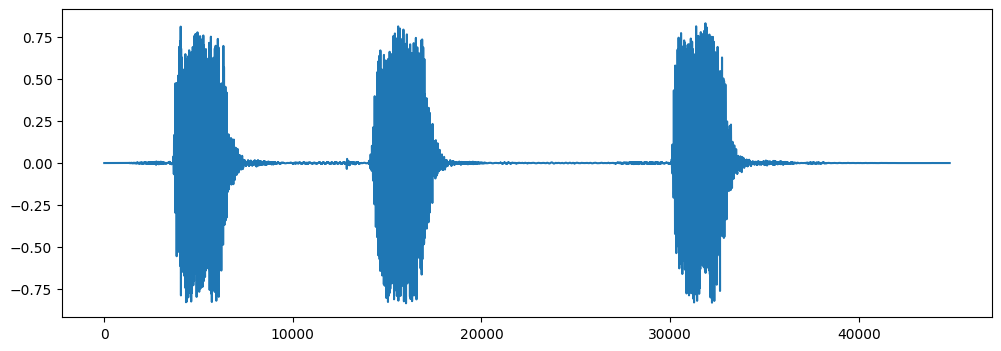

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(librosa_audio_data)

**Observation**<br/>
Here Librosa converts the signal to mono, meaning the channel will always be one. (stereo means 2 channels)

In [ ]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio= wav.read(audio_file_path)

In [ ]:
wave_audio

array([[ 256,  256],
       [ 256,  256],
       [   0,    0],
       ...,
       [ 256, 1280],
       [ 512, 1024],
       [ 256,  512]], dtype=int32)

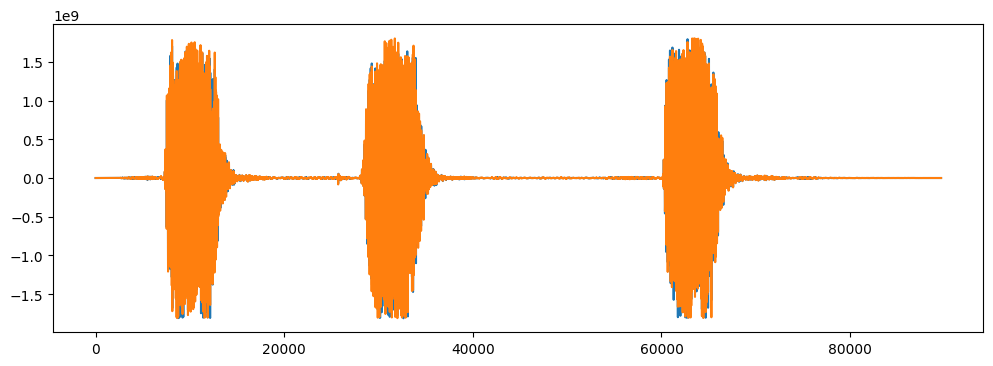

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(wave_audio)

**Extract Features**<br/>
Here we will be using Mel-Frequency Cepstral Coefficients (MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyze both the frequency and the time charateristics of the sound. The audio representations will allow us to identify features for classification.

In [ ]:
mfccs= librosa.feature.mfcc(y=librosa_audio_data, sr= librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 88)


In [ ]:
metadata_df.head()

,File_Name,Start_Time,End_Time,Class
0,angry_22.wav,0,2.080000,angry
1,happy_45.wav,0,5.000000,happy
2,angry_8.wav,0,8.262676,angry
3,angry_9.wav,0,4.000000,angry
4,happy_47.wav,0,1.890000,happy


In [ ]:
def features_extractor(file):
  audio, sample_rate= librosa.load(file, res_type='kaiser_fast')
  mfccs_features= librosa.feature.mfcc(y=audio, sr= sample_rate, n_mfcc=40)
  mfccs_scaled_features= np.mean(mfccs_features.T , axis=0)
  return mfccs_scaled_features

In [ ]:
!pip install --upgrade resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.7 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import resampy

extracted_features= []
for index_num, row in tqdm(metadata_df.iterrows()):
  file_name= os.path.join(os.path.abspath(path)+'/',str(row["File_Name"]))
  final_class_labels= row["Class"]
  data= features_extractor(file_name)
  extracted_features.append([data, final_class_labels])

200it [00:50,  3.93it/s]


In [ ]:
!pip show resampy

Name: resampy
Version: 0.4.2
Summary: Efficient signal resampling
Home-page: https://github.com/bmcfee/resampy
Author: Brian McFee
Author-email: brian.mcfee@nyu.edu
License: ISC
Location: /usr/local/lib/python3.10/dist-packages
Requires: numba, numpy
Required-by: 


In [ ]:
extracted_features_df= pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head()

,feature,class
0,"[-303.87823, 133.94948, -20.448854, 24.511597,...",angry
1,"[-569.43396, 31.936527, 0.65314204, 1.6708603,...",happy
2,"[-396.4329, 76.25201, 27.272411, 8.170999, 2.4...",angry
3,"[-403.45078, 93.77245, 17.812965, -11.735519, ...",angry
4,"[-274.98367, 112.529, -34.67252, -19.668827, -...",happy


In [ ]:
## Split tyhe dataset into idependent and dependent dataset
X= np.array(extracted_features_df['feature'].tolist())
y= np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape

(200, 40)

In [ ]:
y= np.array(pd.get_dummies(y))

In [ ]:
y.shape

(200, 4)

In [ ]:
#Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=0)

In [ ]:
X_train

array([[-3.3115625e+02,  8.1865494e+01, -1.2817248e+01, ...,
        -1.6098765e+00, -1.4386885e+00, -1.5625091e+00],
       [-2.9960861e+02,  4.1762726e+01, -7.8915611e+01, ...,
         6.1729956e-01,  1.4543340e+00,  1.5793740e+00],
       [-2.6963950e+02,  1.5330043e+02, -1.2997303e+01, ...,
        -2.6407614e+00, -3.2527335e+00, -3.6500838e+00],
       ...,
       [-3.7968338e+02,  7.4177124e+01, -2.1628279e+01, ...,
         2.1048361e-01, -6.4544529e-01, -4.5857009e-01],
       [-6.5077393e+01,  1.2843613e+02, -7.5756088e+01, ...,
        -8.1372142e-01,  3.5030572e+00,  2.5042528e-01],
       [-3.6988953e+02,  1.7578954e+02, -1.6954502e+01, ...,
        -3.0032570e+00, -1.0623419e+00, -2.2376134e+00]], dtype=float32)

In [ ]:
y_train

array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0,

In [ ]:
X_train.shape

(160, 40)

In [ ]:
X_test.shape

(40, 40)

In [ ]:
y_train.shape

(160, 4)

In [ ]:
y_test.shape

(40, 4)

## Model Creation

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
num_labels= y.shape[1]

In [ ]:
model= Sequential()
#first layer
model.add(Dense(100, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= 'adam')

In [ ]:
# training my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 400
num_batch_size= 30

checkpointer= ModelCheckpoint(filepath='saved_model/dog_audio_emotion.hdf5', verbose=1, save_best_only=True)

start= datetime.now()

model.fit(X_train, y_train, batch_size= num_batch_size, epochs= num_epochs, validation_data=(X_test, y_test), callbacks= [checkpointer])

duration= datetime.now() - start
print("Training completed in time ",duration)

Epoch 1/400
1/6 [====>.........................] - ETA: 0s - loss: 0.0317 - accuracy: 1.0000
Epoch 1: val_loss improved from inf to 2.34825, saving model to saved_model/dog_audio_emotion.hdf5
6/6 [==============================] - 0s 58ms/step - loss: 0.0426 - accuracy: 0.9875 - val_loss: 2.3482 - val_accuracy: 0.8500
Epoch 2/400
1/6 [====>.........................] - ETA: 0s - loss: 0.0233 - accuracy: 1.0000
Epoch 2: val_loss improved from 2.34825 to 2.20075, saving model to saved_model/dog_audio_emotion.hdf5
6/6 [==============================] - 0s 33ms/step - loss: 0.0470 - accuracy: 0.9875 - val_loss: 2.2007 - val_accuracy: 0.8750
Epoch 3/400
1/6 [====>.........................] - ETA: 0s - loss: 0.0330 - accuracy: 1.0000
Epoch 3: val_loss improved from 2.20075 to 2.17345, saving model to saved_model/dog_audio_emotion.hdf5
6/6 [==============================] - 0s 53ms/step - loss: 0.0608 - accuracy: 0.9875 - val_loss: 2.1734 - val_accuracy: 0.8750
Epoch 4/400
1/6 [====>..........

In [ ]:
test_accuracy= model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy[1])

0.875


In [ ]:
type(model)

keras.src.engine.sequential.Sequential

In [ ]:
!pip install h5py

In [ ]:
import h5py
model.save('dog_audio_model_new.hdf5')

In [ ]:
# Define the class labels
class_labels = ["angry", "happy", "howling", "sad"]

file1= path+'/happy_40.wav'
prediction_feature= features_extractor(file1)
prediction_feature= prediction_feature.reshape(1,-1)
predicted_probabilities = model.predict(prediction_feature)
predicted_class = np.argmax(predicted_probabilities)

# Get the predicted class label
predicted_label = class_labels[predicted_class]

# Print the predicted class label
print("Predicted class:", predicted_label)

1/1 [==============================] - 1s 607ms/step
Predicted class: happy


## Testing some test audio data
Steps

*   Preprocess the new audio
*   Predict the class
*   Inverse transform the predicted label





In [ ]:
file2= "/content/drive/MyDrive/Colab_Datasets/extra_audio/happy14 (10).wav"
audio, sample_rate= librosa.load(file2, res_type="kaiser_fast")
mfccs_features= librosa.feature.mfcc(y=audio, sr= sample_rate, n_mfcc=40)
mfccs_scaled_features= np.mean(mfccs_features.T, axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features= mfccs_scaled_features.reshape(1, -1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_probabilities = model.predict(mfccs_scaled_features)
predicted_label = np.argmax(predicted_probabilities)
labelencoder= LabelEncoder()
labelencoder.fit(class_labels)
predicted_class = labelencoder.inverse_transform([predicted_label])[0]
print(predicted_class)

[-2.9960861e+02  4.1762726e+01 -7.8915611e+01 -2.3142332e+01
 -4.5388935e+01 -1.7579777e+01 -4.4500213e+00  2.2316996e+01
 -5.5414019e+00 -1.0038956e+00 -1.7447479e+01 -8.3142824e+00
  5.5894876e-01  4.7041802e+00 -1.1429214e+01 -4.7386274e+00
 -1.2175715e+01  3.3181965e+00  1.3426679e+00 -1.5277928e+00
 -3.5320046e+00 -2.1987154e+00 -3.9321747e+00 -1.8355829e-01
  4.3296580e+00  4.6258240e+00  9.9623424e-01  2.9667406e+00
 -6.6171247e-01 -3.6010184e+00  3.8335693e-01  5.8403856e-01
  1.2995818e+00 -7.2957313e-01 -7.9670370e-01 -9.4689333e-01
  1.0646731e+00  6.1729956e-01  1.4543340e+00  1.5793740e+00]
[[-2.9960861e+02  4.1762726e+01 -7.8915611e+01 -2.3142332e+01
  -4.5388935e+01 -1.7579777e+01 -4.4500213e+00  2.2316996e+01
  -5.5414019e+00 -1.0038956e+00 -1.7447479e+01 -8.3142824e+00
   5.5894876e-01  4.7041802e+00 -1.1429214e+01 -4.7386274e+00
  -1.2175715e+01  3.3181965e+00  1.3426679e+00 -1.5277928e+00
  -3.5320046e+00 -2.1987154e+00 -3.9321747e+00 -1.8355829e-01
   4.3296580e+00 